In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import lightgbm as lgb
#from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import re

from tqdm import tqdm

random_state = 12345

import json
import os

In [2]:
train_ds = pd.read_csv('data/train_dataset.csv')
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37224 entries, 0 to 37223
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          37224 non-null  object 
 1   time          37224 non-null  int64  
 2   target        37224 non-null  float64
 3   temp          37224 non-null  float64
 4   temp_pred     37136 non-null  float64
 5   weather_pred  37136 non-null  object 
 6   weather_fact  37223 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 2.0+ MB


In [3]:
train_ds['date'] = pd.to_datetime(train_ds['date'])
train_ds['year'] = train_ds['date'].dt.year
train_ds['month'] = train_ds['date'].dt.month
train_ds['day_of_week'] = train_ds['date'].dt.dayofweek
train_ds['day'] = train_ds['date'].dt.day
train_ds['day_of_year'] = train_ds['date'].dt.dayofyear

In [4]:
# функция формирует колонки 'cloudy', 'rainy', 'windy', 'clear', 'some_number'
# в колонках число, которое 0 при отсутсвии упоминания явления в weather_pred или степень упоминания
# функция дает в колонках номер первого списка, элемент которого есть в строке плюс 1
# списки cloudy_list, rainy_list, windy_list, clear_list можно модифицировать
# соответственно, можно экспериментировать с расположением значений в списках
# например, сейчас 'дождь', 'снег', 'д+сн' - первая степень  дождя, а 'гроз', 'ливень' - вторая
# а можно сделать снег второй, а грозу с ливнем убрать в третью
# также сделал отдельный список для "ясности", чтобы выделить 'ясно' и 'солнечно'

def in_what_list(weather, big_list):
    for list_number, small_list in enumerate(big_list):
        if any(word in weather for word in small_list):
            return list_number+1
    return 0

def weather_split2(row):
    weather = row['weather_pred']
    cloudy_list = [['проясн', 'пер.об.', 'п/об'], ['пасм', 'обл']]
    rainy_list = [['дождь', 'снег', 'д+сн'], ['гроз', 'ливень']]
    windy_list = [['вет'],['штор']]
    clear_list = [['проясн'], ['ясно'], ['солнеч']]
    numbers = re.findall(r'\d+', weather)
    cloudy = in_what_list(weather, cloudy_list)
    rainy = in_what_list(weather, rainy_list)
    windy = in_what_list(weather, windy_list)
    clear = in_what_list(weather, clear_list)
    rain_probability = 0 if len(numbers)==0 else int(numbers[0])
    has_rain_probability = int(len(numbers)==0)
    return cloudy, rainy, windy, clear, rain_probability, has_rain_probability

def fill_weather_columns(df):
    df['weather_pred'] = df['weather_pred'].fillna('')
    df['cloudy'], df['rainy'], df['windy'], df['clear'], df['rain_probability'], df['has_rain_probability'] = \
                zip(*df.apply(weather_split2, axis=1))
    return df

train_ds = fill_weather_columns(train_ds)



In [5]:
#tmpds[(tmpds['cloudy']==0) & (tmpds['clear']==0) & (tmpds['rainy']==0)]['weather_pred'].value_counts()

In [6]:
train_ds.columns

Index(['date', 'time', 'target', 'temp', 'temp_pred', 'weather_pred',
       'weather_fact', 'year', 'month', 'day_of_week', 'day', 'day_of_year',
       'cloudy', 'rainy', 'windy', 'clear', 'rain_probability',
       'has_rain_probability'],
      dtype='object')

In [7]:
train_ds.head()

,date,time,target,temp,temp_pred,weather_pred,weather_fact,year,month,day_of_week,day,day_of_year,cloudy,rainy,windy,clear,rain_probability,has_rain_probability
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер,2019,1,1,1,1,2,0,1,0,0,1
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер,2019,1,1,1,1,2,0,1,0,0,1
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер,2019,1,1,1,1,2,0,1,0,0,1
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,1,1,2,0,1,0,0,1
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,1,1,2,0,1,0,0,1


In [8]:
folder_path = 'data/celebrates'

# Получаем список всех файлов JSON в папке
json_files = [file for file in os.listdir(folder_path) if file.endswith('.json')]

# Создаем пустой датафрейм для хранения данных
df_holidays = pd.DataFrame()

# Проходим по каждому файлу JSON
for json_file in json_files:
    # Открываем файл и загружаем данные
    with open(os.path.join(folder_path, json_file), 'r') as file:
        data = json.load(file)
    
    # Преобразуем списки в датафреймы
    df_holidays = pd.DataFrame(data['holidays'], columns=['date'])
    df_preholidays = pd.DataFrame(data['preholidays'], columns=['date'])

    # Добавляем столбцы для праздников и предпраздничных дней
    df_holidays['holidays'] = 1
    df_preholidays['preholidays'] = 1

    # Объединяем датафреймы
    temp_df = pd.concat([df_holidays, df_preholidays])

    # Заполняем пропущенные значения нулями
    temp_df.fillna(0, inplace=True)

    # Добавляем временный датафрейм в общий датафрейм
    df_holidays = pd.concat([df_holidays, temp_df])

# Преобразуем столбец 'date' в формат datetime
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

df_holidays.fillna(0, inplace=True)
df_holidays.to_csv('data/holidays.csv', index=False)
# Выводим первые строки датафрейма
print(df_holidays.sample(10))

          date  holidays  preholidays
57  2020-06-07       1.0          0.0
81  2020-08-23       1.0          0.0
108 2020-11-22       1.0          0.0
46  2020-05-05       1.0          0.0
24  2020-03-01       1.0          0.0
102 2020-11-04       1.0          0.0
22  2020-02-24       1.0          0.0
33  2020-03-29       1.0          0.0
77  2020-08-09       1.0          0.0
115 2020-12-19       1.0          0.0


In [9]:
# Assuming df_holidays and train_ds are your dataframes
train_ds = pd.merge(train_ds, df_holidays, on='date', how='left')

# Fill NaN values with 0
train_ds['holidays'].fillna(0, inplace=True)
train_ds['preholidays'].fillna(0, inplace=True)

# Convert to int
train_ds['holidays'] = train_ds['holidays'].astype(int)
train_ds['preholidays'] = train_ds['preholidays'].astype(int)

In [10]:
train_ds.head()

,date,time,target,temp,temp_pred,weather_pred,weather_fact,year,month,day_of_week,day,day_of_year,cloudy,rainy,windy,clear,rain_probability,has_rain_probability,holidays,preholidays
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер,2019,1,1,1,1,2,0,1,0,0,1,0,0
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер,2019,1,1,1,1,2,0,1,0,0,1,0,0
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер,2019,1,1,1,1,2,0,1,0,0,1,0,0
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,1,1,2,0,1,0,0,1,0,0
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,1,1,2,0,1,0,0,1,0,0


In [11]:
# создаем столбец 'temp_last_day'
train_ds['temp_last_day'] = train_ds['temp'].shift(24) # погода сутки назад
# Среднюю температуру сутки назад
# Максимальную температуру сутки назад
# Минимальный  температуру сутки назад
# заполняем пропущенные значения в 'temp_last_day'
train_ds['temp_last_day'].fillna(method='bfill', inplace=True)

# создаем столбцы с временными лагами для 'target'
lags = [24, 7*24]
for lag in lags:
    train_ds[f'target_lag_{lag}'] = train_ds['target'].shift(lag)

# заполняем пропущенные значения в столбцах с лагами
for lag in lags:
    train_ds[f'target_lag_{lag}'].fillna(0, inplace=True)

/var/folders/4y/zccbjjq17fgd73999h5g3ltr0000gn/T/ipykernel_77615/1625647173.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_ds['temp_last_day'].fillna(method='bfill', inplace=True)


In [12]:
train_ds = train_ds.drop('temp', axis=1)

In [13]:
train_ds.head()

,date,time,target,temp_pred,weather_pred,weather_fact,year,month,day_of_week,day,...,rainy,windy,clear,rain_probability,has_rain_probability,holidays,preholidays,temp_last_day,target_lag_24,target_lag_168
0,2019-01-01,0,481.510,2.0,"пасм, ветер",ветер,2019,1,1,1,...,0,1,0,0,1,0,0,2.9,0.0,0.0
1,2019-01-01,1,462.872,2.0,"пасм, ветер",ветер,2019,1,1,1,...,0,1,0,0,1,0,0,2.9,0.0,0.0
2,2019-01-01,2,449.718,2.0,"пасм, ветер",ветер,2019,1,1,1,...,0,1,0,0,1,0,0,2.9,0.0,0.0
3,2019-01-01,3,430.908,2.0,"пасм, ветер","ветер, пасм",2019,1,1,1,...,0,1,0,0,1,0,0,2.9,0.0,0.0
4,2019-01-01,4,415.163,2.0,"пасм, ветер","ветер, пасм",2019,1,1,1,...,0,1,0,0,1,0,0,2.9,0.0,0.0


In [14]:
feature_cols = list(train_ds.columns)
drop_list = ['target', 'date', 'day_of_year', 'weather_pred', 'weather_fact']
for name in drop_list:
    feature_cols.remove(name)

feature_cols

['time',
 'temp_pred',
 'year',
 'month',
 'day_of_week',
 'day',
 'cloudy',
 'rainy',
 'windy',
 'clear',
 'rain_probability',
 'has_rain_probability',
 'holidays',
 'preholidays',
 'temp_last_day',
 'target_lag_24',
 'target_lag_168']

In [15]:
def mae_day(y_true, y_pred):
    y_true_copy = pd.DataFrame(y_true).reset_index(drop=True)
    y_true_copy['day'] = y_true_copy.index // 24
    y_true_grouped = y_true_copy.groupby(by='day').sum()   
    y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
    y_pred_copy['day'] = y_pred_copy.index // 24
    y_pred_grouped = y_pred_copy.groupby(by='day').sum()
    
    return mean_absolute_error(y_true_grouped, y_pred_grouped)

In [16]:
!pip install statsmodels

In [17]:
# импортируем SARIMAX
import statsmodels.api as sm
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [18]:
feature_cols = list(train_ds.columns)
print(feature_cols)
drop_list = ['date', 'day_of_year', 'weather_pred', 'weather_fact']
for name in drop_list:
    feature_cols.remove(name)

['date', 'time', 'target', 'temp_pred', 'weather_pred', 'weather_fact', 'year', 'month', 'day_of_week', 'day', 'day_of_year', 'cloudy', 'rainy', 'windy', 'clear', 'rain_probability', 'has_rain_probability', 'holidays', 'preholidays', 'temp_last_day', 'target_lag_24', 'target_lag_168']


In [19]:
train_ds_sarrima = train_ds[feature_cols]
train_ds_sarrima.tail()

,time,target,temp_pred,year,month,day_of_week,day,cloudy,rainy,windy,clear,rain_probability,has_rain_probability,holidays,preholidays,temp_last_day,target_lag_24,target_lag_168
40075,19,552.960,6.0,2023,3,4,31,2,0,0,0,61,0,0,0,7.8,561.542,559.747
40076,20,563.985,6.0,2023,3,4,31,2,0,0,0,61,0,0,0,7.8,582.464,570.206
40077,21,560.191,5.0,2023,3,4,31,2,0,0,0,61,0,0,0,7.1,571.899,555.419
40078,22,538.796,5.0,2023,3,4,31,2,0,0,0,61,0,0,0,7.1,545.723,530.734
40079,23,518.685,5.0,2023,3,4,31,2,0,0,0,61,0,0,0,7.1,520.055,511.163


In [20]:
train_ds_sarrima['temp_pred'].fillna(train_ds_sarrima['temp_last_day'], inplace=True)

/var/folders/4y/zccbjjq17fgd73999h5g3ltr0000gn/T/ipykernel_77615/20453516.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ds_sarrima['temp_pred'].fillna(train_ds_sarrima['temp_last_day'], inplace=True)


In [21]:
train_ds_sarrima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40080 entries, 0 to 40079
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time                  40080 non-null  int64  
 1   target                40080 non-null  float64
 2   temp_pred             40080 non-null  float64
 3   year                  40080 non-null  int32  
 4   month                 40080 non-null  int32  
 5   day_of_week           40080 non-null  int32  
 6   day                   40080 non-null  int32  
 7   cloudy                40080 non-null  int64  
 8   rainy                 40080 non-null  int64  
 9   windy                 40080 non-null  int64  
 10  clear                 40080 non-null  int64  
 11  rain_probability      40080 non-null  int64  
 12  has_rain_probability  40080 non-null  int64  
 13  holidays              40080 non-null  int64  
 14  preholidays           40080 non-null  int64  
 15  temp_last_day      

In [22]:
target = train_ds_sarrima['target']

# Выполните тест Дики-Фуллера
result = adfuller(target)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.009688
p-value: 0.001361
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


##### Эти данные - результаты теста Дики-Фуллера, который используется для проверки стационарности временного ряда.

ADF Statistic: Это значение статистики теста. Более отрицательное значение указывает на то, что временной ряд скорее всего является стационарным.

p-value: Это вероятность того, что нулевая гипотеза (временной ряд нестационарен) верна. Если p-value меньше 0.05, мы отвергаем нулевую гипотезу и считаем временной ряд стационарным.

Critical Values: Это значения, которые используются для сравнения со значением статистики теста. Если ADF Statistic меньше (по модулю) критического значения, мы отвергаем нулевую гипотезу.

В вашем случае, ADF Statistic равно -4.009688, что меньше (по модулю) критического значения на уровне 1% (-3.431). Кроме того, p-value равно 0.001361, что меньше 0.05. Это означает, что вы можете отвергнуть нулевую гипотезу и считать ваш временной ряд стационарным.


order=(p, d, q): Это параметры для нерегулярной части модели ARIMA

p: порядок авторегрессии (AR). Это количество лаговых наблюдений в модели 

d: порядок интеграции (I). Это порядок разности, применяемый к временному ряду для достижения стационарности 

q: порядок скользящего среднего (MA)

Выбираем d = 0

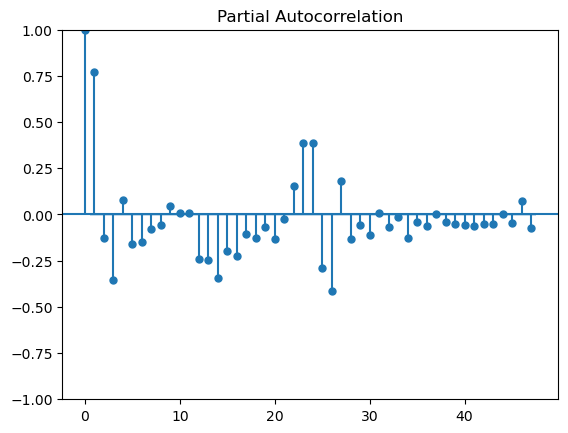

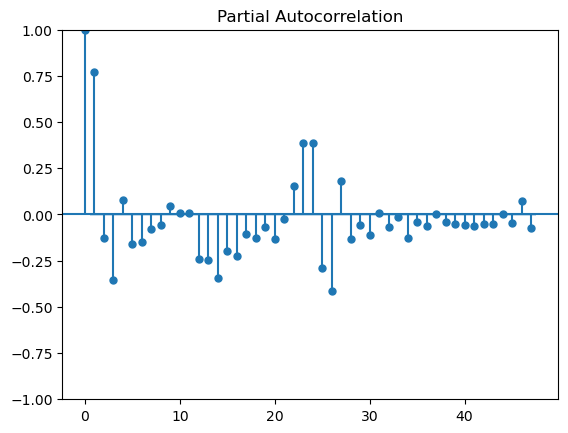

In [23]:
plot_pacf(target.diff().dropna())

На графике PACF каждый столбец представляет собой коэффициент частичной автокорреляции для соответствующего лага. Лаг - это количество временных шагов назад, на которые мы смотрим. Например, лаг 1 означает сравнение текущего значения временного ряда со значением на один шаг назад.

Синие линии вокруг нуля представляют собой доверительные интервалы. Если столбец выходит за эти линии, это означает, что автокорреляция для данного лага статистически значима.

В вашем случае, на основании графика PACF, можно предположить, что параметр p должен быть равен 1, поскольку только первый столбец выходит за доверительные интервалы. Это означает, что есть значимая автокорреляция с одним временным шагом назад.

Второй столбец на графике PACF достигает значения около 0.75, что указывает на то, что есть некоторая автокорреляция с двумя временными шагами назад. Однако, этот столбец не выходит за доверительные интервалы, что означает, что эта автокорреляция может быть случайной.

Тем не менее, это не означает, что вы не можете использовать p=2 в вашей модели. В некоторых случаях, использование большего значения p может улучшить качество прогноза, даже если PACF для этих лагов не выходит за доверительные интервалы. Это может быть полезно, если есть сложные зависимости в ваших данных, которые не могут быть полностью объяснены одним лагом.

Однако, увеличение p также увеличивает сложность модели и может привести к переобучению. Поэтому всегда полезно провести несколько экспериментов с разными значениями параметров и выбрать ту модель, которая дает наилучшее качество прогноза на основе кросс-валидации или других методов оценки модели.

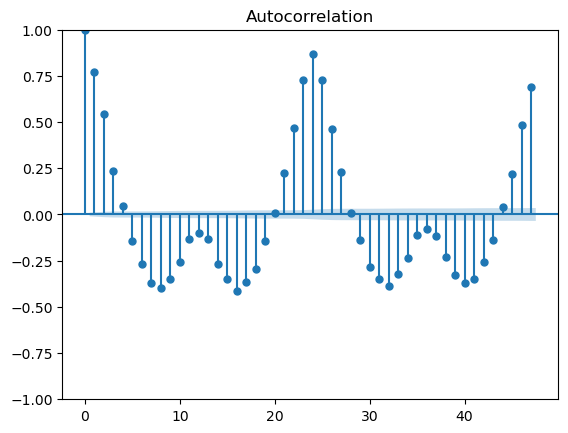

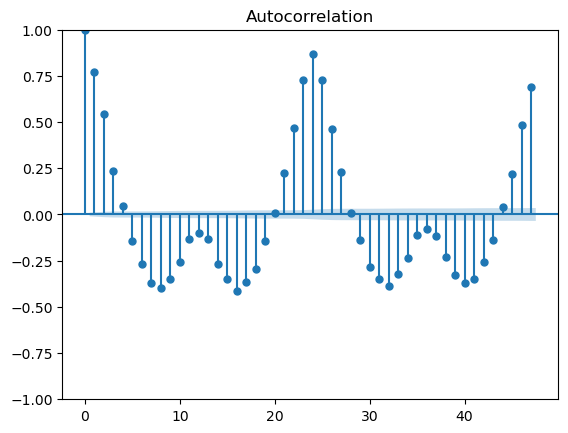

In [24]:
plot_acf(target.diff().dropna())

График, который вы представили, - это график автокорреляционной функции (ACF). Он используется для определения параметра q в модели ARIMA, который относится к порядку скользящего среднего.

На графике ACF каждый столбец представляет собой коэффициент автокорреляции для соответствующего лага. Лаг - это количество временных шагов назад, на которые мы смотрим. Например, лаг 1 означает сравнение текущего значения временного ряда со значением на один шаг назад.

Синие линии вокруг нуля представляют собой доверительные интервалы. Если столбец выходит за эти линии, это означает, что автокорреляция для данного лага статистически значима.

В вашем случае, на основании графика ACF, можно предположить, что параметр q должен быть равен 1 или 2, поскольку первые два столбца выходят за доверительные интервалы. Это означает, что есть значимая автокорреляция с одним и двумя временными шагами назад.

На основании вашего графика PACF:

Параметр P (порядок сезонной авторегрессии) можно выбрать равным 1, поскольку на графике PACF первый столбец выходит за доверительные интервалы.

Параметр Q (порядок сезонного скользящего среднего) также можно выбрать равным 1 или 2, поскольку первые два столбца на графике PACF выходят за доверительные интервалы.

In [25]:
# Разделить данные на обучающий и проверочный наборы

train = train_ds_sarrima[train_ds_sarrima['year']<2023]
valid = train_ds_sarrima[train_ds_sarrima['year']==2023]


# Определить целевую переменную и признаки
target = 'target'
features = train_ds_sarrima.columns.drop(target)

# Создать эндогенные и экзогенные переменные для обучающего набора
endog_train = train[target]
exog_train = sm.add_constant(train[features], prepend=True, has_constant='raise')
exog_train = train[features]



In [26]:
# Создать эндогенные и экзогенные переменные для проверочного набора


endog_valid = valid[target]
exog_valid = sm.add_constant(valid[features], prepend=True, has_constant='add')
exog_valid = valid[features]

In [27]:
print(len(exog_valid.columns))
print(exog_valid.info())


17
<class 'pandas.core.frame.DataFrame'>
Index: 2160 entries, 37920 to 40079
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time                  2160 non-null   int64  
 1   temp_pred             2160 non-null   float64
 2   year                  2160 non-null   int32  
 3   month                 2160 non-null   int32  
 4   day_of_week           2160 non-null   int32  
 5   day                   2160 non-null   int32  
 6   cloudy                2160 non-null   int64  
 7   rainy                 2160 non-null   int64  
 8   windy                 2160 non-null   int64  
 9   clear                 2160 non-null   int64  
 10  rain_probability      2160 non-null   int64  
 11  has_rain_probability  2160 non-null   int64  
 12  holidays              2160 non-null   int64  
 13  preholidays           2160 non-null   int64  
 14  temp_last_day         2160 non-null   float64
 15  target_lag_24     

In [28]:
print(len(exog_train.columns))
print(exog_train.info())

17
<class 'pandas.core.frame.DataFrame'>
Index: 37920 entries, 0 to 37919
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time                  37920 non-null  int64  
 1   temp_pred             37920 non-null  float64
 2   year                  37920 non-null  int32  
 3   month                 37920 non-null  int32  
 4   day_of_week           37920 non-null  int32  
 5   day                   37920 non-null  int32  
 6   cloudy                37920 non-null  int64  
 7   rainy                 37920 non-null  int64  
 8   windy                 37920 non-null  int64  
 9   clear                 37920 non-null  int64  
 10  rain_probability      37920 non-null  int64  
 11  has_rain_probability  37920 non-null  int64  
 12  holidays              37920 non-null  int64  
 13  preholidays           37920 non-null  int64  
 14  temp_last_day         37920 non-null  float64
 15  target_lag_24        

In [31]:
ARIMA_p=1
ARIMA_d=0
ARRIMA_q=1

#SARIMA (P, D, Q, s)

SARIMA_P=1 
SARIMA_D=0 
SARIMA_Q=1
SARIMA_s=24

TREND = 'c'

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.24122D+00    |proj g|=  7.93258D-01


 This problem is unconstrained.



At iterate    5    f=  3.94652D+00    |proj g|=  1.37116D-01

At iterate   10    f=  3.77087D+00    |proj g|=  7.84616D-02

At iterate   15    f=  3.57810D+00    |proj g|=  8.91091D-02

At iterate   20    f=  3.55441D+00    |proj g|=  7.21801D-03

At iterate   25    f=  3.54586D+00    |proj g|=  3.95162D-02

At iterate   30    f=  3.54151D+00    |proj g|=  2.69007D-02

At iterate   35    f=  3.54062D+00    |proj g|=  5.93173D-03

At iterate   40    f=  3.53975D+00    |proj g|=  1.43002D-02

At iterate   45    f=  3.53900D+00    |proj g|=  2.06550D-02


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.53716D+00    |proj g|=  6.30722D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     59      1     0     0   6.307D-03   3.537D+00
  F =   3.5371598766270331     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
mean absolute error: 20.20196856091064
mean absolute percentage error: 3.7944462505591523


/var/folders/4y/zccbjjq17fgd73999h5g3ltr0000gn/T/ipykernel_77615/3988927389.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predicted_sarimax'] = predict.values
/var/folders/4y/zccbjjq17fgd73999h5g3ltr0000gn/T/ipykernel_77615/3988927389.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['residual_sarimax'] = abs(valid['target']-valid['predicted_sarimax'])  # Используйте 'target' вместо 'avg_energy'


<Axes: >

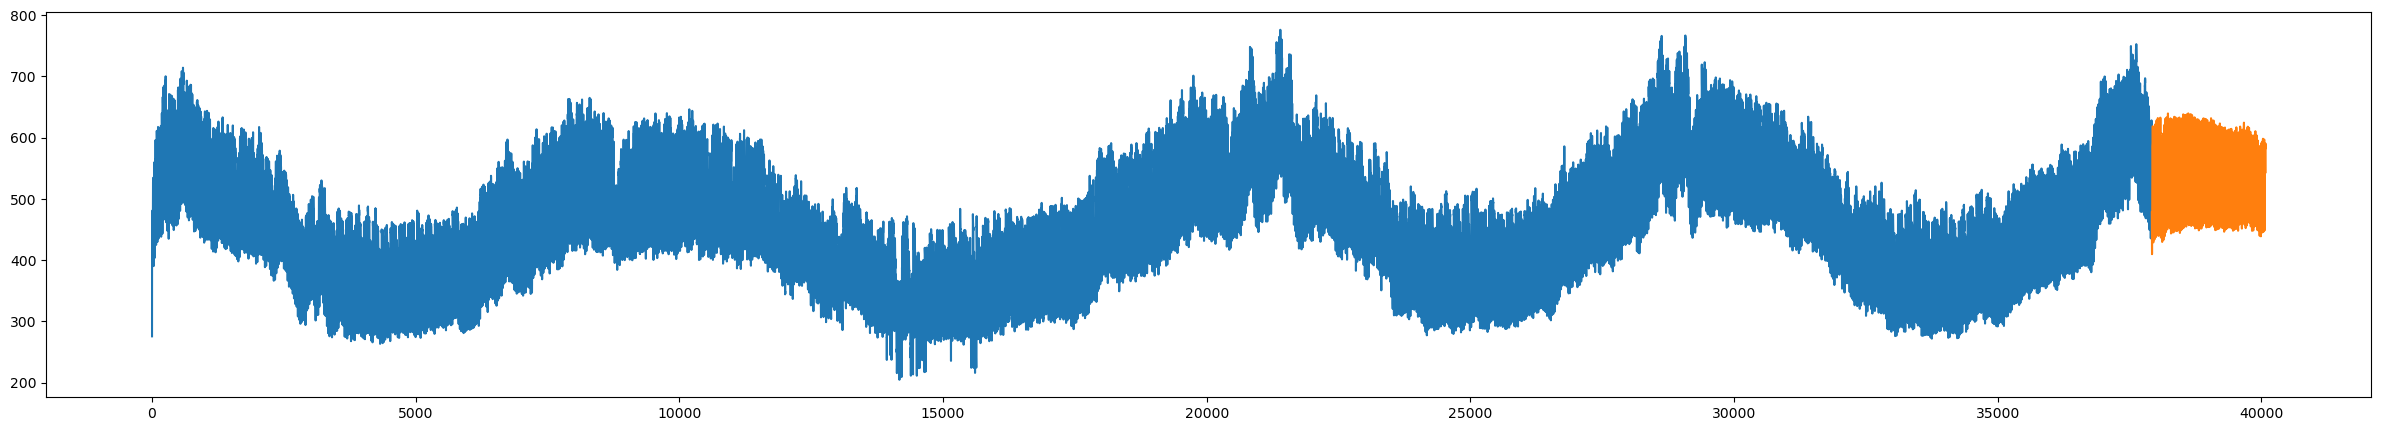

In [32]:


mod = sm.tsa.statespace.SARIMAX(endog=endog_train, exog=exog_train, order=(ARIMA_p,ARIMA_d,ARRIMA_q),
                                seasonal_order=(SARIMA_P,SARIMA_D,SARIMA_Q, SARIMA_s),trend=TREND)
model_fit = mod.fit()
model_fit.summary()


predict = model_fit.predict(start = len(train),
                            end = len(train)+len(valid)-1,
                            exog = exog_valid)


valid['predicted_sarimax'] = predict.values
valid['residual_sarimax'] = abs(valid['target']-valid['predicted_sarimax'])  # Используйте 'target' вместо 'avg_energy'
MAE = valid['residual_sarimax'].sum()/len(valid)
MAPE = (abs(valid['residual_sarimax'])/valid['target']).sum()*100/len(valid)  # Используйте 'target' вместо 'avg_energy'
print("mean absolute error:", MAE)
print("mean absolute percentage error:", MAPE)

# Построение графиков
model_fit.fittedvalues.plot(figsize = (30,5))
valid.predicted_sarimax.plot()

In [33]:
print("mean absolute error:", MAE)
print("mean absolute percentage error:", MAPE)

mean absolute error: 20.20196856091064
mean absolute percentage error: 3.7944462505591523
